# Yield Curve Interpolation and Government Bond Future Contract

For June 2021 Maturity, US Ultra-Long Bond(USM1), US Ten Year (TYM1) and UK Long Gilt (G_M1), Futures Contracts, the deliverable bonds against each of these contracts are given.

- A) For each of the above bonds, using Cubic Spline interpolation and CMY From the US Fed and nominal zero-coupon yield from Bank of England find the time series of daily prices, YTM, Duration and Convexity for each bond from 1/1/2020-2/28/2021.
- B) Find the daily rate of return of each bond and conversion factor adjusted return (conversion factor adjusted return is simply the daily return multiply by the conversion factor)
- C) For each Day, identify the Cheapest to Delivery Bond for each of the above contract (DCTD) .
- D) Find the conversion factor adjusted daily rate of return of the above DCTD bonds for each Futures contracts.
- E) Calculate the actual daily rate of return of the three Futures contract in the given time period.
- F) For all three contracts, compare and comment on the daily rate of return in D and E.

In [371]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import time
import datetime as dt
import sympy
import math
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import dateutil
from IPython.display import display, HTML

In [372]:
# utils for yield interpolation, bonds price, ytm, duration, convextiy calculation

def get_yield_today(today_yield):
    yield_curve = interp1d(today_yield.index.values, today_yield.values, kind='cubic', fill_value='extrapolate')
    return yield_curve

class FixedIncomePricer:
    def __init__(self):
        self.settlement_date = None
        self.pv = None
        self.value = None
        self.pvbp = None
        self.ytm = 0.0
        self.duration = None
        self.modified_duration = None
        self.yield_curve = None
        self.effective_duration = None
        self.convexity = None
        self.effective_convexity = None
        self.payment_table = None

    def BuildCashFlow(self):
        pass

    def BuildPaymentTable(self, ytm):
        self.BuildCashFlow()
        self.payment_table['years'] = (self.payment_table.index - self.settlement_date).days / 365
        self.payment_table['n'] = (self.payment_table['years'] / 0.5).apply(int)
        self.payment_table['t'] = ((self.payment_table['years'] / 0.5) - self.payment_table['n'])
        self.payment_table['discount_factor'] = (1 + ytm / 2) ** (-(self.payment_table['n'] + self.payment_table['t']))
        self.payment_table['pv_payment'] = self.payment_table['payment'] * self.payment_table['discount_factor']

        self.pv = self.payment_table['pv_payment'].sum()
        return abs(self.pv - self.value)

    def BuildPaymentTableFromYield(self):
        self.BuildCashFlow()
        self.payment_table['years'] = (self.payment_table.index - self.settlement_date).days / 365
        self.payment_table['n'] = (self.payment_table['years'] / 0.5).apply(int)
        self.payment_table['t'] = ((self.payment_table['years'] / 0.5) - self.payment_table['n'])
        self.payment_table['yield'] = self.yield_curve(self.payment_table['years']) / 100
        # self.payment_table['discount_factor'] = np.exp(-(self.payment_table['years'] * self.payment_table['yield']))
        self.payment_table['discount_factor'] = 1 / ((1+self.payment_table['yield']) ** self.payment_table['years'])
        self.payment_table['pv_payment'] = self.payment_table['payment'] * self.payment_table['discount_factor']

        self.value = self.payment_table['pv_payment'].sum()

    def SolvePrice(self):
        self.BuildPaymentTableFromYield()

    def SolveYTM(self):
        result = opt.minimize(self.BuildPaymentTable,
                              x0=[0.01],
                              tol=10e-10,
                              method='BFGS',
                              ).x
        self.ytm = float(result)

    def SolvePVBP(self):
        self.pvbp = self.modified_duration * self.value * 0.0001

    def SolveDuration(self):
        self.duration = float((self.payment_table['pv_payment'] * self.payment_table['years']).sum() / self.value)

    def SolveModifiedDuration(self):
        self.modified_duration = self.duration / (1 + self.ytm)

    def SolveEffectiveDuration(self):
        # https://www.investopedia.com/terms/e/effectiveduration.asp
        dy = 0.0001
        V = self.value
        self.BuildPaymentTable(self.ytm + dy)
        V_plus = self.pv
        self.BuildPaymentTable(self.ytm - dy)
        V_minus = self.pv
        self.effective_duration = (V_minus - V_plus) / (2 * V * dy)

        self.BuildPaymentTable(self.ytm)

    def SolveConvexity(self):
        # https://www.educba.com/convexity-formula/
        self.convexity = float(1 / self.value / (1 + self.ytm/2)**2 * (self.payment_table['pv_payment'] * self.payment_table['years'] * (1 + self.payment_table['years'])).sum())

    def SolveEffectiveConvexity(self):
        # https://en.wikipedia.org/wiki/Bond_convexity
        dy = 0.0001
        V = self.value
        self.BuildPaymentTable(self.ytm + dy)
        V_plus = self.pv
        self.BuildPaymentTable(self.ytm - dy)
        V_minus = self.pv
        self.effective_convexity = (V_minus - 2 * V + V_plus)/ (V * dy**2)

        self.BuildPaymentTable(self.ytm)


class BondPricer(FixedIncomePricer):
    def __init__(self, settlement_date, maturity_date, yield_curve, price, coupon_rate, freq, par):
        super().__init__()
        self.settlement_date = settlement_date
        self.maturity_date = maturity_date
        self.yield_curve = yield_curve
        self.value = price
        self.coupon_rate = coupon_rate
        self.freq = freq
        self.par = par

        self.pv = None

        self.ytm = 0.0
        self.duration = None
        self.modified_duration = None
        self.effective_duration = None
        self.convexity = None
        self.effective_convexity = None
        self.coupon_dates = self.GetCouponDates(self.settlement_date, self.maturity_date)
        self.payment_table = pd.DataFrame(index=self.coupon_dates)

    def BuildCashFlow(self):
        self.payment_table['payment'] = self.coupon_rate * self.par / self.freq
        self.payment_table['payment'][-1] = self.payment_table['payment'][-1] + self.par

    def GetCouponDates(self, start_date, end_date):
        if end_date.day == 15:
            coupon_dates = []
            coupon_date = end_date
            while coupon_date >= start_date:
                coupon_dates.append(coupon_date)
                coupon_date = coupon_date - dateutil.relativedelta.relativedelta(months=12 / self.freq)
            return pd.Index(sorted(coupon_dates))
        else:
            periods = int((end_date - start_date).days / 180 + 1)
            coupon_dates = pd.date_range(end=end_date, freq=pd.offsets.MonthEnd(12 / self.freq), periods=periods)
            coupon_dates = coupon_dates[coupon_dates >= start_date]
            return coupon_dates


def SolvePricer(pricer):
    pricer.SolvePrice()
    pricer.SolveYTM()
    pricer.BuildPaymentTable(pricer.ytm)
    pricer.SolveDuration()
    # pricer.SolveModifiedDuration()
    # pricer.SolvePVBP()
    # pricer.SolveEffectiveDuration()
    pricer.SolveConvexity()
    # pricer.SolveEffectiveConvexity()

In [373]:
def solve_A(bond_df, rate_df, name):
    result_list = []

    # A
    for each_yield in range(len(rate_df)):
        t1 = time.time()
        valid_yield = rate_df.iloc[each_yield].dropna()
        if len(valid_yield) == 0:
            continue
        yield_curve = get_yield_today(valid_yield)
        print('run: ', rate_df.index[each_yield])

        output = pd.DataFrame(columns=('Date', 'Bond', 'DailyPrice', 'MarketPrice', 'YTM', 'Duration', 'Convexity'))
        for i in range(len(bond_df)):
            start_date = rate_df.index[each_yield]
            a = bond_df.loc[i, "Cash Security"].split()[-1]
            formatted = "20" + a.split("/")[-1] + "/" + a.split("/")[0] + "/" + a.split("/")[1]

            bp = BondPricer(settlement_date=start_date,
                            maturity_date=pd.to_datetime(formatted),
                            yield_curve=yield_curve,
                            price=bond_df.loc[i, "Cash Security"],
                            coupon_rate=bond_df.loc[i, "Coupon"]/100,
                            freq=2,
                            par=100)
            SolvePricer(bp)

            output = output.append([{'Date': rate_df.index[each_yield],
                                     'Bond': bond_df.loc[i, "Cash Security"],
                                     'DailyPrice': bp.value,
                                     'MarketPrice': bond_df.loc[i, "Price"],
                                     'ConverFactor': bond_df.loc[i, "Conver Factor"],
                                     'YTM': bp.ytm,
                                     'Duration': bp.duration,
                                     'Convexity': bp.convexity}], ignore_index=True)
        t2 = time.time()
        print(t2 - t1)
        result_list.append(output)

    result_df = pd.concat(result_list)
    result_df.to_csv(f'{name}_output.csv', index=False, encoding='utf_8_sig')

In [397]:

def solve_other(name):
    # B
    result_df = pd.read_csv(f'{name}_output.csv')
    tickers = result_df.columns
    bonds_name = result_df['Bond'].unique()
    dates = result_df['Date']
    result_df['AdjDailyPrice'] = result_df['DailyPrice'] * result_df['ConverFactor']
    price_df = pd.pivot_table(result_df, values='DailyPrice', index=['Date'], columns=['Bond'], aggfunc=np.sum)[bonds_name]
    adjprice_df = pd.pivot_table(result_df, values='AdjDailyPrice', index=['Date'], columns=['Bond'], aggfunc=np.sum)[bonds_name]
    dailyret_df = price_df.pct_change(periods=1).fillna(0)

    factor_df = pd.pivot_table(result_df, values='ConverFactor', index=['Date'], columns=['Bond'], aggfunc=np.sum)[bonds_name]
    adjret_df = dailyret_df * factor_df

    ytm_df = pd.pivot_table(result_df, values='YTM', index=['Date'], columns=['Bond'], aggfunc=np.sum)[bonds_name]
    duration_df = pd.pivot_table(result_df, values='Duration', index=['Date'], columns=['Bond'], aggfunc=np.sum)[bonds_name]
    convexity_df = pd.pivot_table(result_df, values='Convexity', index=['Date'], columns=['Bond'], aggfunc=np.sum)[bonds_name]
    

    # C
    # dctd_df = adjprice_df.idxmin(axis=1)
    #dctd_df = (adjprice_df.fillna(0).cumsum()).idxmin(axis=1)
    #dctd_df = (price_df - factor_df*100).idxmin(axis=1)
    dctd_df = (price_df.iloc[0, :] * (adjret_df.fillna(0).cumsum()+1)).idxmin(axis=1)
    #dctd_df = find_DCTD(name, adjprice_df,factor_df,price_df)
    # D
    adjret_dctd_df = pd.Series([adjret_df.loc[i, dctd_df[i]] for i in dates.unique()], index=dates.unique())

    synthetic_price = pd.Series([price_df.loc[i, dctd_df[i]] * factor_df.loc[i, dctd_df[i]] for i in dates.unique()], 
                                index=dates.unique())
    # E
    # dailyret_future_df =
    dailyret_future_df = synthetic_price.pct_change(periods=1).fillna(0)

    rets_df = pd.DataFrame({'DCTD adjusted ret': adjret_dctd_df,
                            'Futures ret': dailyret_future_df})

    return_result = {
        # 'all': result_df,
        'price': price_df,
        'YTM': ytm_df,
        'Duration': duration_df,
        'Convexity': convexity_df,

        'adjusted price': adjprice_df,
        'daily return': dailyret_df,
        'adjusted return': adjret_df,
        'DCTD': dctd_df,
        'adjusted return for DCTD': adjret_dctd_df,
    }
    return return_result, rets_df


In [119]:
USM1 = pd.read_excel("USTYG_RX_20210308.xlsx", sheet_name="USM1")
TYM1 = pd.read_excel("USTYG_RX_20210308.xlsx", sheet_name="TYM1")
G_M1 = pd.read_excel("USTYG_RX_20210308.xlsx", sheet_name="G_M1")



FileNotFoundError: [Errno 2] No such file or directory: 'USTYG_RX_20210308.xlsx'

In [375]:
# solve_A(USM1, US_yield, name='USM1')
# solve_A(TYM1, US_yield, name='TYM1')
# solve_A(G_M1, UK_yield, name='G_M1')
UK_yield = pd.read_excel("UK_Yield.xlsx", index_col='Date')
US_yield = pd.read_excel("US_Yield.xlsx", index_col='Date')

In [376]:
USM1_result, USM1_rets = solve_other(name='USM1')
TYM1_result, TYM1_rets = solve_other(name='TYM1')
G_M1_result, G_M1_rets = solve_other(name='G_M1')


## Yield Curve Result

In [377]:
def plot_yield(f, valid_yield, date, end_year=30):
    xi = valid_yield.index
    yi = valid_yield.values
    xnew = np.arange(0.1, end_year, 0.1)
    ynew = f(xnew)   # use interpolation function returned by `interp1d`
    plt.plot(xi, yi, 'o') 
    plt.plot(xnew, ynew, '-', label=date)


In [378]:
US_yield

,0.083333,0.166667,0.250000,0.500000,1.000000,2.000000,3.000000,5.000000,7.000000,10.000000,20.000000,30.000000
Date,,,,,,,,,,,,
2020-01-02,1.53,1.55,1.54,1.57,1.56,1.58,1.59,1.67,1.79,1.88,2.19,2.33
2020-01-03,1.52,1.55,1.52,1.55,1.55,1.53,1.54,1.59,1.71,1.80,2.11,2.26
2020-01-06,1.54,1.54,1.56,1.56,1.54,1.54,1.56,1.61,1.72,1.81,2.13,2.28
2020-01-07,1.52,1.53,1.54,1.56,1.53,1.54,1.55,1.62,1.74,1.83,2.16,2.31
2020-01-08,1.50,1.53,1.54,1.56,1.55,1.58,1.61,1.67,1.78,1.87,2.21,2.35
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,0.03,0.02,0.03,0.04,0.06,0.11,0.22,0.61,1.00,1.37,2.02,2.19
2021-02-23,0.03,0.02,0.04,0.05,0.08,0.11,0.22,0.59,1.00,1.37,2.03,2.21
2021-02-24,0.03,0.03,0.03,0.05,0.08,0.12,0.24,0.62,1.02,1.38,2.07,2.24


In [379]:
UK_yield

,0.083333,0.166667,0.250000,0.333333,0.416667,0.500000,0.583333,0.666667,0.750000,0.833333,...,4.250000,4.333333,4.416666,4.500000,4.583333,4.666666,4.750000,4.833333,4.916666,5.000000
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0.572733,0.554150,0.537397,0.522640,...,0.626752,0.632677,0.638734,0.644932,0.651280,0.657787,0.664460,0.671308,0.678336,0.685552
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,0.569617,0.550312,0.532435,0.516221,...,0.570232,0.575911,0.581745,0.587742,0.593908,0.600252,0.606781,0.613500,0.620415,0.627531
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0.606692,0.586997,0.568867,0.552466,...,0.592980,0.598362,0.603910,0.609632,0.615535,0.621626,0.627914,0.634403,0.641099,0.648006
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,0.616413,0.598556,0.582039,0.567112,...,0.633611,0.638771,0.644068,0.649511,0.655108,0.660868,0.666797,0.672903,0.679192,0.685668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,NaN,NaN,NaN,-0.056040,-0.050395,-0.044824,-0.038945,-0.032567,-0.025664,-0.018217,...,0.589064,0.607804,0.626575,0.645369,0.664173,0.682977,0.701773,0.720552,0.739304,0.758021
2021-02-23,NaN,NaN,NaN,-0.058090,-0.055306,-0.052518,-0.049065,-0.044664,-0.039332,-0.033094,...,0.622750,0.643316,0.663891,0.684460,0.705008,0.725524,0.745998,0.766418,0.786774,0.807055
2021-02-24,NaN,NaN,NaN,-0.058472,-0.054270,-0.049958,-0.045273,-0.040074,-0.034308,-0.027923,...,0.663927,0.685885,0.707828,0.729740,0.751607,0.773414,0.795151,0.816805,0.838366,0.859824


Text(0, 0.5, 'Yield')

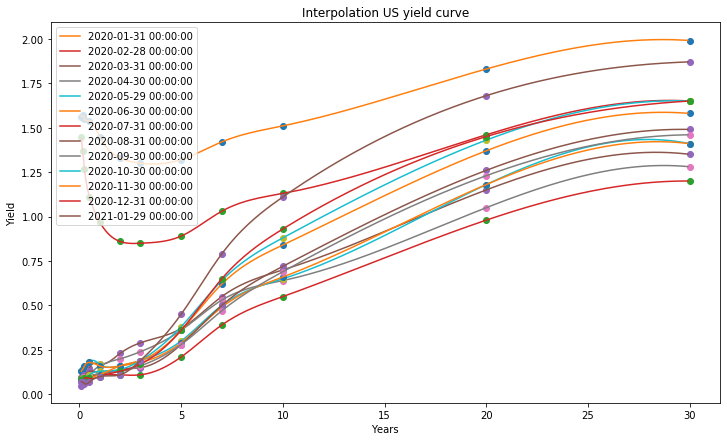

In [380]:
# US yield curve
rate_df = US_yield
plt.figure(figsize=(12,7))
for each_yield in range(len(rate_df)-1):
    if rate_df.index[each_yield].month != rate_df.index[each_yield+1].month:
        valid_yield = rate_df.iloc[each_yield].dropna()
        if len(valid_yield) == 0:
            continue
        yield_curve = get_yield_today(valid_yield)
        plot_yield(yield_curve, valid_yield, str(rate_df.index[each_yield]))
plt.legend(loc='upper left')
plt.title('Interpolation US yield curve')
plt.xlabel('Years')
plt.ylabel('Yield')

Text(0, 0.5, 'Yield')

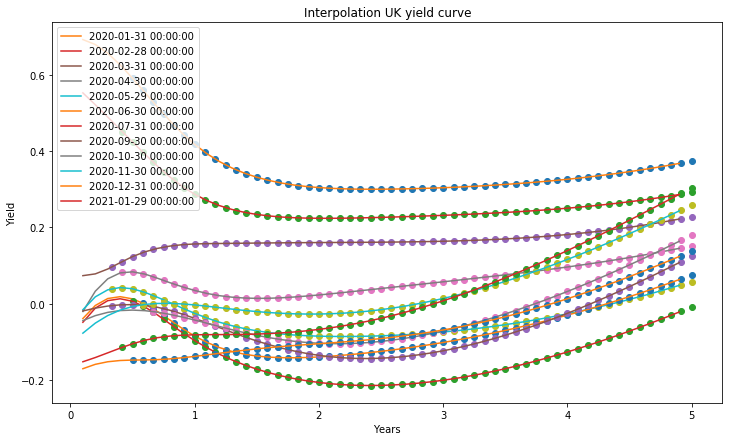

In [381]:
# UK yield curve
rate_df = UK_yield
plt.figure(figsize=(12,7))
for each_yield in range(len(rate_df)-1):
    if rate_df.index[each_yield].month != rate_df.index[each_yield+1].month:
        valid_yield = rate_df.iloc[each_yield].dropna()
        if len(valid_yield) == 0:
            continue
        yield_curve = get_yield_today(valid_yield)
        plot_yield(yield_curve, valid_yield, str(rate_df.index[each_yield]), end_year=5)
plt.legend(loc='upper left')
plt.title('Interpolation UK yield curve')
plt.xlabel('Years')
plt.ylabel('Yield')

## Results for USM1

In [382]:
for k, v in USM1_result.items():
    print(k)
    display(v.head(10))

price


Bond,T 5 05/15/37,T 4 ¾ 02/15/37,T 4 ⅜ 02/15/38,T 4 ½ 05/15/38,T 4 ½ 08/15/39,T 4 ¼ 05/15/39,T 4 ⅝ 02/15/40,T 4 ⅜ 11/15/39,T 4 ⅜ 05/15/40,T 4 ¾ 02/15/41,...,T 3 11/15/44,T 1 ⅜ 11/15/40,T 3 05/15/45,T 1 ⅛ 05/15/40,T 3 11/15/45,T 2 ⅞ 08/15/45,T 1 ⅛ 08/15/40,T 2 ½ 02/15/45,T 2 ½ 02/15/46,T 2 ½ 05/15/46
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,143.938779,141.034697,136.593273,137.736192,140.299293,134.847153,142.963729,137.385367,137.895672,146.309240,...,115.285081,86.873097,115.378850,83.118364,115.470495,113.643679,83.129240,106.102775,106.022997,105.397258
2020-01-03,145.418872,142.473042,138.059788,139.231343,141.867991,136.372114,144.575737,138.952551,139.489238,147.991797,...,116.843824,88.091070,116.951747,84.294243,117.057628,115.200817,84.309576,107.579724,107.523320,106.903578
2020-01-06,145.139494,142.204378,137.771319,138.934126,141.540578,136.055104,144.233728,138.621194,139.146267,147.623421,...,116.455967,87.806041,116.557333,84.022305,116.656984,114.808097,84.034066,107.206201,107.138822,106.516297
2020-01-07,144.710865,141.791308,137.326967,138.476711,141.031904,135.564277,143.700435,138.106305,138.611272,147.044592,...,115.831524,87.357901,115.921813,83.596639,116.011432,114.174440,83.601541,106.603201,106.518205,105.892098
2020-01-08,143.883079,140.990586,136.492024,137.621425,140.111667,134.672970,142.746490,137.181942,137.662747,146.032654,...,114.848000,86.608829,114.929871,82.879144,115.012634,113.192166,82.877431,105.666754,105.571407,104.943622
2020-01-09,144.553365,141.640964,137.170020,138.312677,140.834194,135.379731,143.481757,137.902400,138.387854,146.777512,...,115.330317,87.178167,115.369709,83.442691,115.403858,113.599634,83.437799,106.093743,105.900980,105.246237
2020-01-10,144.907898,141.976851,137.554549,138.716088,141.330517,135.848507,144.024882,138.415786,138.945001,147.420489,...,116.337629,87.677499,116.444943,83.893309,116.550541,114.701901,83.908110,107.103636,107.048181,106.428460
2020-01-13,144.559557,141.638044,137.210360,138.365475,140.965373,135.492680,143.650690,138.051168,138.575179,147.031688,...,115.975605,87.394483,116.077969,83.619081,116.178051,114.337656,83.633361,106.759741,106.694477,106.071817
2020-01-14,145.262228,142.321543,137.912926,139.081097,141.715069,136.223528,144.418652,138.800050,139.334691,147.827509,...,116.688137,87.989631,116.792065,84.198546,116.893743,115.042414,84.213570,107.433533,107.369248,106.747009


YTM


Bond,T 5 05/15/37,T 4 ¾ 02/15/37,T 4 ⅜ 02/15/38,T 4 ½ 05/15/38,T 4 ½ 08/15/39,T 4 ¼ 05/15/39,T 4 ⅝ 02/15/40,T 4 ⅜ 11/15/39,T 4 ⅜ 05/15/40,T 4 ¾ 02/15/41,...,T 3 11/15/44,T 1 ⅜ 11/15/40,T 3 05/15/45,T 1 ⅛ 05/15/40,T 3 11/15/45,T 2 ⅞ 08/15/45,T 1 ⅛ 08/15/40,T 2 ½ 02/15/45,T 2 ½ 02/15/46,T 2 ½ 05/15/46
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.020291,0.020249,0.020545,0.020595,0.020906,0.020872,0.021011,0.020980,0.021098,0.021223,...,0.022161,0.021697,0.033121,0.021618,0.022282,0.022278,0.021686,0.022292,0.022406,0.022429
2020-01-03,0.019487,0.019444,0.019744,0.019796,0.020116,0.020080,0.020226,0.020192,0.020314,0.020445,...,0.021419,0.020917,0.021488,0.020832,0.021549,0.021544,0.020903,0.021554,0.021677,0.021702
2020-01-06,0.019652,0.019607,0.019914,0.019967,0.020293,0.020257,0.020404,0.020370,0.020494,0.020627,...,0.021613,0.021109,0.021682,0.021023,0.021744,0.021738,0.021095,0.021750,0.033454,0.021897
2020-01-07,0.019890,0.019844,0.020161,0.020216,0.020554,0.020517,0.028841,0.020634,0.020762,0.020899,...,0.021915,0.021400,0.021984,0.021312,0.022046,0.022042,0.021386,0.022056,0.022179,0.022203
2020-01-08,0.020348,0.020301,0.020626,0.020682,0.021026,0.020988,0.021143,0.021108,0.021237,0.021376,...,0.022392,0.021889,0.022459,0.021801,0.022517,0.022515,0.021876,0.022533,0.022649,0.022671
2020-01-09,0.019984,0.019937,0.020256,0.020313,0.020662,0.020621,0.020784,0.020745,0.020880,0.021031,...,0.022163,0.021523,0.022253,0.021422,0.022337,0.022323,0.021502,0.022319,0.022489,0.022525
2020-01-10,0.019795,0.019752,0.020049,0.020100,0.020415,0.020380,0.020522,0.020490,0.020608,0.020736,...,0.032441,0.021204,0.021748,0.021123,0.021806,0.021801,0.021191,0.021814,0.021929,0.021952
2020-01-13,0.019998,0.019956,0.020251,0.020301,0.020612,0.020578,0.020717,0.020686,0.020803,0.020929,...,0.021866,0.021397,0.021930,0.021317,0.021988,0.021984,0.021384,0.021996,0.022111,0.033775
2020-01-14,0.019619,0.019575,0.019869,0.019920,0.020236,0.020200,0.020345,0.020311,0.020431,0.020563,...,0.021529,0.021017,0.021598,0.020931,0.021660,0.021653,0.021001,0.021662,0.021786,0.021810


Duration


Bond,T 5 05/15/37,T 4 ¾ 02/15/37,T 4 ⅜ 02/15/38,T 4 ½ 05/15/38,T 4 ½ 08/15/39,T 4 ¼ 05/15/39,T 4 ⅝ 02/15/40,T 4 ⅜ 11/15/39,T 4 ⅜ 05/15/40,T 4 ¾ 02/15/41,...,T 3 11/15/44,T 1 ⅜ 11/15/40,T 3 05/15/45,T 1 ⅛ 05/15/40,T 3 11/15/45,T 2 ⅞ 08/15/45,T 1 ⅛ 08/15/40,T 2 ½ 02/15/45,T 2 ½ 02/15/46,T 2 ½ 05/15/46
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,12.770987,12.641769,13.390456,13.567322,14.134233,14.256501,14.327167,14.454262,14.719192,14.768399,...,18.201620,17.939385,14.526905,17.973487,18.717458,18.616859,18.101496,18.831572,19.368894,19.613407
2020-01-03,12.794696,12.665287,13.416988,13.593942,14.166295,14.286355,14.361231,14.486115,14.752887,14.806368,...,18.250496,17.962475,18.510249,17.992334,18.770702,18.669794,18.121833,18.880688,19.422464,19.666817
2020-01-06,12.781072,12.651752,13.402572,13.579450,14.150304,14.270892,14.344668,14.470088,14.736309,14.788649,...,18.228798,17.947919,18.487892,17.978883,18.747671,18.646856,18.107971,18.858738,14.876333,19.643511
2020-01-07,12.770506,12.641304,13.390782,13.567547,14.136063,14.257462,12.436629,14.455770,14.721114,14.771649,...,18.205067,17.935539,18.463102,17.968218,18.721819,18.621120,18.096656,18.834516,19.372784,19.617168
2020-01-08,12.752671,12.623648,13.371036,13.547670,14.112485,14.235280,14.304547,14.432204,14.696235,14.743910,...,18.169024,17.916567,18.425691,17.952022,18.683045,18.582454,18.079449,18.798137,19.333682,19.578254
2020-01-09,12.761909,12.632779,13.381843,13.558519,14.125808,14.247681,14.318635,14.445407,14.710120,14.759241,...,18.182324,17.925994,18.438033,17.959707,18.694131,18.594323,18.087753,18.810462,19.343326,19.586791
2020-01-10,12.765405,12.636070,13.386675,13.563603,14.133977,14.254862,14.328195,14.453902,14.720026,14.771964,...,14.433152,17.933804,18.472145,17.965202,18.731978,18.631123,18.094171,18.843283,19.383832,19.628329
2020-01-13,12.750494,12.621199,13.371085,13.548001,14.117077,14.238501,14.310821,14.437067,14.702759,14.753670,...,18.192055,17.919229,18.450611,17.951656,18.709820,18.609082,18.080268,18.822257,19.361553,14.986630
2020-01-14,12.760238,12.630865,13.382288,13.559232,14.130871,14.251291,14.325510,14.450761,14.717280,14.770066,...,18.212746,17.929031,18.472108,17.959488,18.732148,18.631364,18.088801,18.843009,19.383958,19.628288


Convexity


Bond,T 5 05/15/37,T 4 ¾ 02/15/37,T 4 ⅜ 02/15/38,T 4 ½ 05/15/38,T 4 ½ 08/15/39,T 4 ¼ 05/15/39,T 4 ⅝ 02/15/40,T 4 ⅜ 11/15/39,T 4 ⅜ 05/15/40,T 4 ¾ 02/15/41,...,T 3 11/15/44,T 1 ⅜ 11/15/40,T 3 05/15/45,T 1 ⅛ 05/15/40,T 3 11/15/45,T 2 ⅞ 08/15/45,T 1 ⅛ 08/15/40,T 2 ½ 02/15/45,T 2 ½ 02/15/46,T 2 ½ 05/15/46
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,204.976251,201.343379,225.054057,230.073173,253.191868,253.837762,261.486090,262.290350,272.645317,279.907997,...,410.877674,365.368357,324.926807,361.040613,436.672498,432.322932,367.647003,434.952573,462.385030,471.916167
2020-01-03,205.632359,201.981780,225.802995,230.840233,254.134612,254.728016,262.499937,263.250691,273.675500,281.069009,...,412.623305,366.221061,425.478100,361.770756,438.622032,434.236056,368.420562,436.729447,464.370922,473.928654
2020-01-06,205.269421,201.626020,225.404351,230.433067,253.670226,254.274295,262.012618,262.774339,273.174696,280.532408,...,411.839390,365.690227,424.660116,361.271891,437.768744,433.394561,367.907079,435.919499,346.112668,473.034303
2020-01-07,204.982980,201.347383,225.075226,230.094654,253.254276,253.877240,223.184272,262.345932,272.713062,280.015228,...,410.988776,365.236322,423.760481,360.868499,436.818736,432.459939,367.482908,435.037206,462.505295,472.035644
2020-01-08,204.497463,200.874896,224.523224,229.528362,252.565522,253.220997,260.825848,261.640537,271.957258,279.171622,...,409.700251,364.541167,422.406320,360.254115,435.397623,431.059851,366.837353,433.716661,461.050816,470.565033
2020-01-09,204.754847,201.124117,224.828893,229.841954,252.957274,253.591079,261.245055,262.038737,272.381734,279.640165,...,410.172146,364.889106,422.849372,360.554189,435.800177,431.484873,367.154156,434.157842,461.403270,470.881939
2020-01-10,204.854762,201.216086,224.966998,229.990547,253.198293,253.806482,261.530268,262.295890,272.685298,280.029590,...,317.956827,365.178238,424.079730,360.770881,437.182581,432.811298,367.400385,435.341456,462.900797,472.443066
2020-01-13,204.457496,200.825331,224.536481,229.552689,252.708514,253.327293,261.020189,261.796549,272.164797,279.476820,...,410.509561,364.647970,423.293357,360.269580,436.363172,432.004158,366.886563,434.566822,462.059552,350.869873
2020-01-14,204.728714,201.088884,224.853240,229.877194,253.114101,253.708976,261.457278,262.209551,272.608756,279.977941,...,411.245839,365.010321,424.067829,360.575880,437.177695,432.806032,367.212646,435.313683,462.885888,472.423327


adjusted price


Bond,T 5 05/15/37,T 4 ¾ 02/15/37,T 4 ⅜ 02/15/38,T 4 ½ 05/15/38,T 4 ½ 08/15/39,T 4 ¼ 05/15/39,T 4 ⅝ 02/15/40,T 4 ⅜ 11/15/39,T 4 ⅜ 05/15/40,T 4 ¾ 02/15/41,...,T 3 11/15/44,T 1 ⅜ 11/15/40,T 3 05/15/45,T 1 ⅛ 05/15/40,T 3 11/15/45,T 2 ⅞ 08/15/45,T 1 ⅛ 08/15/40,T 2 ½ 02/15/45,T 2 ½ 02/15/46,T 2 ½ 05/15/46
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,129.386568,123.405360,113.549988,116.084063,117.332299,109.280133,121.176057,112.820863,112.867608,125.445542,...,72.214575,41.368969,71.846410,37.877039,71.499331,68.777154,37.549478,59.640370,58.704933,58.147667
2020-01-03,130.717024,124.663911,114.769101,117.344176,118.644201,110.515962,122.542394,114.107835,114.171941,126.888167,...,73.190971,41.948967,72.825853,38.412887,72.482084,69.719535,38.082635,60.470563,59.535662,58.978704
2020-01-06,130.465891,124.428831,114.529297,117.093681,118.370386,110.259057,122.252508,113.835724,113.891219,126.572321,...,72.948018,41.813237,72.580251,38.288964,72.234005,69.481860,37.958188,60.260605,59.322766,58.765041
2020-01-07,130.080597,124.067394,114.159908,116.708172,117.944982,109.861290,121.800488,113.412898,113.453326,126.076033,...,72.556867,41.599832,72.184513,38.094989,71.834279,69.098371,37.762816,59.921659,58.979130,58.420670
2020-01-08,129.336500,123.366763,113.465819,115.987337,117.175388,109.138975,120.991925,112.653811,112.676959,125.208398,...,71.940787,41.243124,71.566831,37.768026,71.215823,68.503899,37.435736,59.395283,58.454888,57.897396
2020-01-09,129.939019,123.935844,114.029438,116.569924,117.779636,109.711734,121.615137,113.245451,113.270458,125.847039,...,72.242910,41.514243,71.840718,38.024834,71.458069,68.750499,37.688854,59.635293,58.637373,58.064349
2020-01-10,130.257709,124.229745,114.349097,116.909919,118.194712,110.091630,122.075490,113.667043,113.726483,126.398327,...,72.873891,41.752025,72.510266,38.230181,72.168095,69.417591,37.901293,60.202954,59.272578,58.716581
2020-01-13,129.944586,123.933289,114.062972,116.614422,117.889342,109.803268,121.758325,113.367619,113.423784,126.064969,...,72.647119,41.617253,72.281751,38.105215,71.937449,69.197150,37.777189,60.009651,59.076732,58.519821
2020-01-14,130.576216,124.531350,114.647016,117.217549,118.516312,110.395547,122.409250,113.982601,114.045445,126.747306,...,73.093449,41.900663,72.726419,38.369277,72.380605,69.623669,38.039270,60.388389,59.450352,58.892325


daily return


Bond,T 5 05/15/37,T 4 ¾ 02/15/37,T 4 ⅜ 02/15/38,T 4 ½ 05/15/38,T 4 ½ 08/15/39,T 4 ¼ 05/15/39,T 4 ⅝ 02/15/40,T 4 ⅜ 11/15/39,T 4 ⅜ 05/15/40,T 4 ¾ 02/15/41,...,T 3 11/15/44,T 1 ⅜ 11/15/40,T 3 05/15/45,T 1 ⅛ 05/15/40,T 3 11/15/45,T 2 ⅞ 08/15/45,T 1 ⅛ 08/15/40,T 2 ½ 02/15/45,T 2 ½ 02/15/46,T 2 ½ 05/15/46
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.010283,0.010199,0.010736,0.010855,0.011181,0.011309,0.011276,0.011407,0.011556,0.011500,...,0.013521,0.014020,0.013632,0.014147,0.013745,0.013702,0.014199,0.013920,0.014151,0.014292
2020-01-06,-0.001921,-0.001886,-0.002089,-0.002135,-0.002308,-0.002325,-0.002366,-0.002385,-0.002459,-0.002489,...,-0.003319,-0.003236,-0.003372,-0.003226,-0.003423,-0.003409,-0.003268,-0.003472,-0.003576,-0.003623
2020-01-07,-0.002953,-0.002905,-0.003225,-0.003292,-0.003594,-0.003608,-0.003697,-0.003714,-0.003845,-0.003921,...,-0.005362,-0.005104,-0.005452,-0.005066,-0.005534,-0.005519,-0.005147,-0.005625,-0.005793,-0.005860
2020-01-08,-0.005720,-0.005647,-0.006080,-0.006176,-0.006525,-0.006575,-0.006638,-0.006693,-0.006843,-0.006882,...,-0.008491,-0.008575,-0.008557,-0.008583,-0.008609,-0.008603,-0.008661,-0.008784,-0.008889,-0.008957
2020-01-09,0.004659,0.004613,0.004967,0.005023,0.005157,0.005248,0.005151,0.005252,0.005267,0.005101,...,0.004200,0.006574,0.003827,0.006800,0.003402,0.003600,0.006761,0.004041,0.003122,0.002884
2020-01-10,0.002453,0.002371,0.002803,0.002917,0.003524,0.003463,0.003785,0.003723,0.004026,0.004381,...,0.008734,0.005728,0.009320,0.005400,0.009936,0.009703,0.005637,0.009519,0.010833,0.011233
2020-01-13,-0.002404,-0.002386,-0.002502,-0.002528,-0.002584,-0.002619,-0.002598,-0.002634,-0.002662,-0.002637,...,-0.003112,-0.003228,-0.003151,-0.003269,-0.003196,-0.003176,-0.003274,-0.003211,-0.003304,-0.003351
2020-01-14,0.004861,0.004826,0.005120,0.005172,0.005318,0.005394,0.005346,0.005425,0.005481,0.005413,...,0.006144,0.006810,0.006152,0.006930,0.006160,0.006164,0.006938,0.006311,0.006324,0.006365


adjusted return


Bond,T 5 05/15/37,T 4 ¾ 02/15/37,T 4 ⅜ 02/15/38,T 4 ½ 05/15/38,T 4 ½ 08/15/39,T 4 ¼ 05/15/39,T 4 ⅝ 02/15/40,T 4 ⅜ 11/15/39,T 4 ⅜ 05/15/40,T 4 ¾ 02/15/41,...,T 3 11/15/44,T 1 ⅜ 11/15/40,T 3 05/15/45,T 1 ⅛ 05/15/40,T 3 11/15/45,T 2 ⅞ 08/15/45,T 1 ⅛ 08/15/40,T 2 ½ 02/15/45,T 2 ½ 02/15/46,T 2 ½ 05/15/46
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.009243,0.008924,0.008925,0.009149,0.009351,0.009165,0.009557,0.009368,0.009459,0.009860,...,0.008469,0.006676,0.008489,0.006447,0.008511,0.008292,0.006414,0.007824,0.007835,0.007885
2020-01-06,-0.001727,-0.001650,-0.001737,-0.001799,-0.001930,-0.001884,-0.002005,-0.001958,-0.002012,-0.002134,...,-0.002079,-0.001541,-0.002100,-0.001470,-0.002119,-0.002063,-0.001476,-0.001952,-0.001980,-0.001999
2020-01-07,-0.002655,-0.002542,-0.002681,-0.002775,-0.003006,-0.002924,-0.003134,-0.003050,-0.003147,-0.003362,...,-0.003359,-0.002430,-0.003395,-0.002309,-0.003427,-0.003340,-0.002325,-0.003162,-0.003207,-0.003233
2020-01-08,-0.005142,-0.004941,-0.005054,-0.005205,-0.005457,-0.005328,-0.005627,-0.005496,-0.005601,-0.005900,...,-0.005319,-0.004083,-0.005328,-0.003911,-0.005331,-0.005207,-0.003912,-0.004938,-0.004922,-0.004942
2020-01-09,0.004188,0.004036,0.004129,0.004233,0.004313,0.004253,0.004366,0.004313,0.004311,0.004373,...,0.002631,0.003130,0.002383,0.003099,0.002106,0.002179,0.003054,0.002271,0.001729,0.001591
2020-01-10,0.002205,0.002075,0.002330,0.002458,0.002947,0.002806,0.003208,0.003057,0.003295,0.003756,...,0.005471,0.002728,0.005803,0.002461,0.006153,0.005872,0.002546,0.005351,0.005998,0.006197
2020-01-13,-0.002161,-0.002088,-0.002080,-0.002130,-0.002161,-0.002123,-0.002202,-0.002163,-0.002179,-0.002261,...,-0.001949,-0.001537,-0.001962,-0.001490,-0.001979,-0.001922,-0.001479,-0.001805,-0.001830,-0.001849
2020-01-14,0.004369,0.004222,0.004257,0.004359,0.004448,0.004371,0.004531,0.004455,0.004486,0.004641,...,0.003848,0.003243,0.003831,0.003158,0.003814,0.003730,0.003134,0.003548,0.003502,0.003512


DCTD


Date
2020-01-02    T 1 ⅛ 05/15/40
2020-01-03    T 1 ⅛ 05/15/40
2020-01-06    T 1 ⅛ 05/15/40
2020-01-07    T 1 ⅛ 05/15/40
2020-01-08    T 1 ⅛ 05/15/40
2020-01-09    T 1 ⅛ 05/15/40
2020-01-10    T 1 ⅛ 05/15/40
2020-01-13    T 1 ⅛ 05/15/40
2020-01-14    T 1 ⅛ 05/15/40
2020-01-15    T 1 ⅛ 05/15/40
dtype: object

adjusted return for DCTD


2020-01-02    0.000000
2020-01-03    0.006447
2020-01-06   -0.001470
2020-01-07   -0.002309
2020-01-08   -0.003911
2020-01-09    0.003099
2020-01-10    0.002461
2020-01-13   -0.001490
2020-01-14    0.003158
2020-01-15    0.002440
dtype: float64

test


Bond,T 5 05/15/37,T 4 ¾ 02/15/37,T 4 ⅜ 02/15/38,T 4 ½ 05/15/38,T 4 ½ 08/15/39,T 4 ¼ 05/15/39,T 4 ⅝ 02/15/40,T 4 ⅜ 11/15/39,T 4 ⅜ 05/15/40,T 4 ¾ 02/15/41,...,T 3 11/15/44,T 1 ⅜ 11/15/40,T 3 05/15/45,T 1 ⅛ 05/15/40,T 3 11/15/45,T 2 ⅞ 08/15/45,T 1 ⅛ 08/15/40,T 2 ½ 02/15/45,T 2 ½ 02/15/46,T 2 ½ 05/15/46
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.8989,0.875,0.8313,0.8428,0.8363,0.8104,0.8476,0.8212,0.8185,0.8574,...,0.6264,0.4762,0.6227,0.4557,0.6192,0.6052,0.4517,0.5621,0.5537,0.5517
2020-01-03,0.8989,0.875,0.8313,0.8428,0.8363,0.8104,0.8476,0.8212,0.8185,0.8574,...,0.6264,0.4762,0.6227,0.4557,0.6192,0.6052,0.4517,0.5621,0.5537,0.5517
2020-01-06,0.8989,0.875,0.8313,0.8428,0.8363,0.8104,0.8476,0.8212,0.8185,0.8574,...,0.6264,0.4762,0.6227,0.4557,0.6192,0.6052,0.4517,0.5621,0.5537,0.5517
2020-01-07,0.8989,0.875,0.8313,0.8428,0.8363,0.8104,0.8476,0.8212,0.8185,0.8574,...,0.6264,0.4762,0.6227,0.4557,0.6192,0.6052,0.4517,0.5621,0.5537,0.5517
2020-01-08,0.8989,0.875,0.8313,0.8428,0.8363,0.8104,0.8476,0.8212,0.8185,0.8574,...,0.6264,0.4762,0.6227,0.4557,0.6192,0.6052,0.4517,0.5621,0.5537,0.5517
2020-01-09,0.8989,0.875,0.8313,0.8428,0.8363,0.8104,0.8476,0.8212,0.8185,0.8574,...,0.6264,0.4762,0.6227,0.4557,0.6192,0.6052,0.4517,0.5621,0.5537,0.5517
2020-01-10,0.8989,0.875,0.8313,0.8428,0.8363,0.8104,0.8476,0.8212,0.8185,0.8574,...,0.6264,0.4762,0.6227,0.4557,0.6192,0.6052,0.4517,0.5621,0.5537,0.5517
2020-01-13,0.8989,0.875,0.8313,0.8428,0.8363,0.8104,0.8476,0.8212,0.8185,0.8574,...,0.6264,0.4762,0.6227,0.4557,0.6192,0.6052,0.4517,0.5621,0.5537,0.5517
2020-01-14,0.8989,0.875,0.8313,0.8428,0.8363,0.8104,0.8476,0.8212,0.8185,0.8574,...,0.6264,0.4762,0.6227,0.4557,0.6192,0.6052,0.4517,0.5621,0.5537,0.5517


Text(0.5, 1.0, 'USM1 adjusted daily return, first 30 days')

<Figure size 432x288 with 0 Axes>

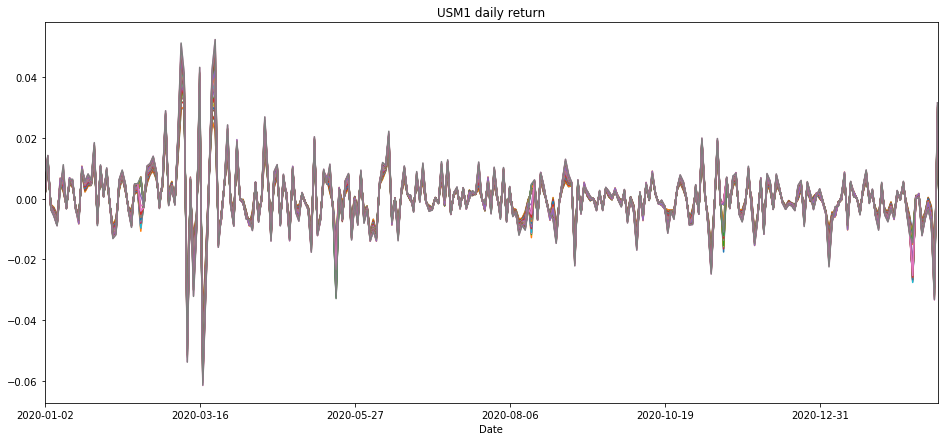

<Figure size 432x288 with 0 Axes>

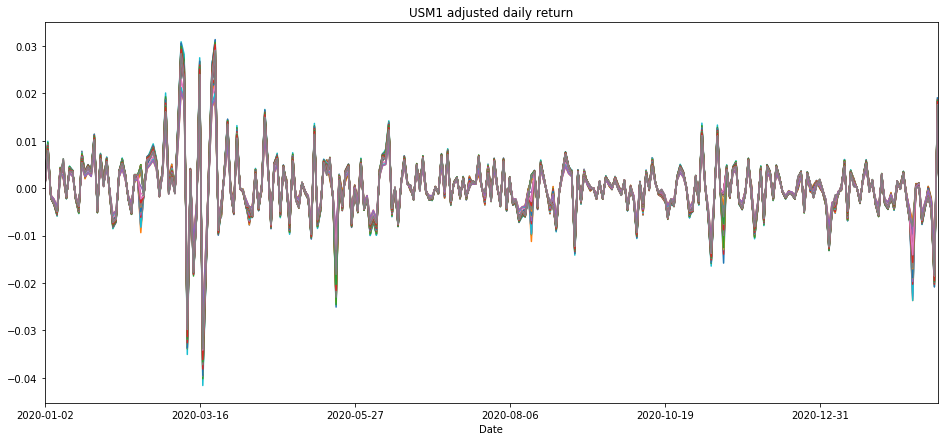

<Figure size 432x288 with 0 Axes>

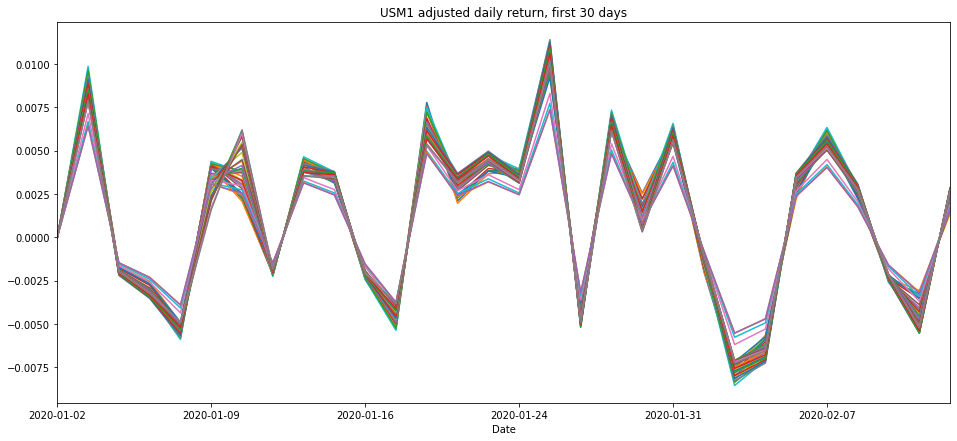

In [384]:
plt.figure()
USM1_result['daily return'].plot(figsize=(16,7), legend=False)
plt.title('USM1 daily return')

plt.figure()
USM1_result['adjusted return'].plot(figsize=(16,7), legend=False)
plt.title('USM1 adjusted daily return')


plt.figure()
USM1_result['adjusted return'].head(30).plot(figsize=(16,7), legend=False)
plt.title('USM1 adjusted daily return, first 30 days')

## Results for TYM1

In [385]:
for k, v in TYM1_result.items():
    print(k)
    display(v.head(10))

price


Bond,T 2 ¾ 02/15/28,T 2 ⅞ 05/15/28,T 1 ⅛ 02/29/28,T 2 ⅞ 08/15/28,T 0 ¾ 01/31/28,T 0 ⅝ 12/31/27,T 3 ⅛ 11/15/28,T 2 ⅝ 02/15/29,T 2 ⅜ 05/15/29,T 1 ⅝ 08/15/29,T 1 ¾ 11/15/29,T 1 ½ 02/15/30,T 0 ⅝ 05/15/30,T 0 ⅝ 08/15/30,T 0 ⅞ 11/15/30,T 1 ⅛ 02/15/31
Date,,,,,,,,,,,,,,,,
2020-01-02,108.084402,108.536354,95.119405,109.423321,92.297064,91.151519,110.954768,107.565019,104.852705,98.605575,99.246309,97.204195,88.339954,88.183447,90.206747,92.765474
2020-01-03,108.688157,109.160560,95.688501,110.066389,92.853018,91.699965,111.624393,108.241216,105.541523,99.291222,99.955738,97.924556,89.046623,88.907384,90.957763,93.544171
2020-01-06,108.636259,109.106050,95.641674,110.009575,92.807779,91.655422,111.562989,108.178106,105.474875,99.223199,99.882166,97.847341,88.968543,88.824532,90.868662,93.448873
2020-01-07,108.494966,108.960044,95.504341,109.859057,92.672730,91.521977,111.407110,108.019739,105.313419,99.061098,99.715270,97.677558,88.800008,88.651876,90.690002,93.263814
2020-01-08,108.192398,108.647031,95.222978,109.536872,92.398858,91.252162,111.071386,107.682328,104.970671,98.722056,99.364328,97.321866,88.453060,88.296030,90.319591,92.878348
2020-01-09,108.290134,108.753902,95.313871,109.653635,92.485549,91.335879,111.200771,107.820928,105.120343,98.880276,99.537388,97.507280,88.645276,88.502281,90.542284,93.117807
2020-01-10,108.500557,108.964983,95.513090,109.863896,92.682425,91.532087,111.411505,108.025485,105.320184,99.070170,99.725265,97.689528,88.815211,88.669142,90.709205,93.285320
2020-01-13,108.373964,108.833424,95.392993,109.727628,92.565040,91.416277,111.268398,107.879533,105.169801,98.918598,99.566909,97.527189,88.653881,88.502662,90.535541,93.104484
2020-01-14,108.549261,109.020519,95.560472,109.926996,92.727190,91.574460,111.482521,108.103689,105.405530,99.162077,99.825631,97.797618,88.928371,88.790344,90.839269,93.424476


YTM


Bond,T 2 ¾ 02/15/28,T 2 ⅞ 05/15/28,T 1 ⅛ 02/29/28,T 2 ⅞ 08/15/28,T 0 ¾ 01/31/28,T 0 ⅝ 12/31/27,T 3 ⅛ 11/15/28,T 2 ⅝ 02/15/29,T 2 ⅜ 05/15/29,T 1 ⅝ 08/15/29,T 1 ¾ 11/15/29,T 1 ½ 02/15/30,T 0 ⅝ 05/15/30,T 0 ⅝ 08/15/30,T 0 ⅞ 11/15/30,T 1 ⅛ 02/15/31
Date,,,,,,,,,,,,,,,,
2020-01-02,0.018123,0.018185,0.018210,0.018249,0.018205,0.018185,0.018297,0.018377,0.018441,0.018533,0.018580,0.018649,0.018757,0.018817,0.018862,0.018908
2020-01-03,0.017360,0.017422,0.017443,0.017485,0.017437,0.017416,0.017531,0.017606,0.017666,0.017752,0.017795,0.017859,0.017960,0.018016,0.018059,0.018102
2020-01-06,0.017445,0.017508,0.017525,0.017572,0.017518,0.017497,0.017620,0.017696,0.017758,0.017846,0.017893,0.017959,0.018063,0.018123,0.018169,0.018216
2020-01-07,0.017632,0.017695,0.017718,0.017758,0.017712,0.017692,0.017806,0.017884,0.017947,0.018038,0.018084,0.018152,0.018259,0.018320,0.018365,0.018413
2020-01-08,0.018026,0.018088,0.018107,0.018152,0.018101,0.018081,0.018201,0.018278,0.018343,0.018433,0.018481,0.018551,0.018659,0.018722,0.018770,0.018820
2020-01-09,0.017907,0.017963,0.017990,0.018018,0.017986,0.017968,0.018057,0.018125,0.018178,0.018257,0.018293,0.018351,0.018445,0.018496,0.018534,0.018575
2020-01-10,0.017645,0.017708,0.017724,0.017772,0.017717,0.017696,0.017820,0.017895,0.017957,0.018044,0.018089,0.018155,0.018257,0.018315,0.018359,0.018405
2020-01-13,0.017827,0.017891,0.017907,0.017955,0.017900,0.017880,0.018004,0.018082,0.018146,0.018235,0.018283,0.018351,0.018456,0.018516,0.018562,0.018608
2020-01-14,0.017609,0.017666,0.017685,0.017722,0.017680,0.017661,0.017763,0.017830,0.017883,0.017961,0.017999,0.018057,0.018149,0.018200,0.018239,0.018280


Duration


Bond,T 2 ¾ 02/15/28,T 2 ⅞ 05/15/28,T 1 ⅛ 02/29/28,T 2 ⅞ 08/15/28,T 0 ¾ 01/31/28,T 0 ⅝ 12/31/27,T 3 ⅛ 11/15/28,T 2 ⅝ 02/15/29,T 2 ⅜ 05/15/29,T 1 ⅝ 08/15/29,T 1 ¾ 11/15/29,T 1 ½ 02/15/30,T 0 ⅝ 05/15/30,T 0 ⅝ 08/15/30,T 0 ⅞ 11/15/30,T 1 ⅛ 02/15/31
Date,,,,,,,,,,,,,,,,
2020-01-02,7.299699,7.516639,7.780777,7.668187,7.820880,7.804286,7.855320,8.138360,8.458539,8.884758,9.088181,9.365011,10.024468,10.240478,10.353085,10.410707
2020-01-03,7.299920,7.516947,7.779547,7.669032,7.819205,7.802296,7.856371,8.139598,8.459543,8.885367,9.089001,9.365960,10.023537,10.239836,10.353159,10.411920
2020-01-06,7.291369,7.508383,7.771167,7.660407,7.810874,7.793998,7.847711,8.130914,8.450877,8.876744,9.080339,9.357271,10.015083,10.231339,10.344555,10.403147
2020-01-07,7.287905,7.504900,7.768048,7.656792,7.807865,7.791068,7.844052,8.127205,8.447227,8.873185,9.076733,9.353633,10.011900,10.228084,10.341127,10.399440
2020-01-08,7.283639,7.500589,7.764542,7.652206,7.804586,7.787950,7.839360,8.122428,8.442577,8.868748,9.072190,9.349029,10.008253,10.224291,10.336970,10.394702
2020-01-09,7.281358,7.498351,7.762033,7.650095,7.802005,7.785320,7.837330,8.120482,8.440632,8.866766,9.070303,9.347224,10.005998,10.222142,10.335056,10.393167
2020-01-10,7.279636,7.496627,7.759815,7.648510,7.799638,7.782845,7.835765,8.118927,8.438960,8.864938,9.068489,9.345400,10.003686,10.219876,10.332928,10.391259
2020-01-13,7.270711,7.487680,7.751237,7.639432,7.791166,7.774447,7.826634,8.109746,8.429830,8.855899,9.059394,9.336267,9.995016,10.211132,10.324002,10.382043
2020-01-14,7.268815,7.485838,7.748934,7.637787,7.788731,7.771920,7.825089,8.108307,8.428356,8.854336,9.057938,9.334899,9.992972,10.209220,10.322391,10.380915


Convexity


Bond,T 2 ¾ 02/15/28,T 2 ⅞ 05/15/28,T 1 ⅛ 02/29/28,T 2 ⅞ 08/15/28,T 0 ¾ 01/31/28,T 0 ⅝ 12/31/27,T 3 ⅛ 11/15/28,T 2 ⅝ 02/15/29,T 2 ⅜ 05/15/29,T 1 ⅝ 08/15/29,T 1 ¾ 11/15/29,T 1 ½ 02/15/30,T 0 ⅝ 05/15/30,T 0 ⅝ 08/15/30,T 0 ⅞ 11/15/30,T 1 ⅛ 02/15/31
Date,,,,,,,,,,,,,,,,
2020-01-02,63.352681,66.830897,69.047864,69.927515,69.124303,68.446066,73.214294,78.145835,83.343876,90.474296,94.503280,99.918058,110.723892,115.575159,118.831100,121.453774
2020-01-03,63.390342,66.872417,69.072193,69.977059,69.143586,68.461755,73.269611,78.206421,83.406126,90.535887,94.571636,99.991761,110.779505,115.638082,118.907489,121.548845
2020-01-06,63.255461,66.733412,68.931148,69.834558,69.002482,68.321322,73.123044,78.054420,83.248302,90.370854,94.401906,99.816361,110.595137,115.448723,118.713901,121.351164
2020-01-07,63.194074,66.669665,68.869344,69.767844,68.941578,68.261412,73.053829,77.981928,83.173288,90.292987,94.321187,99.732472,110.511008,115.361375,118.622584,121.254937
2020-01-08,63.111221,66.583066,68.789966,69.675948,68.864557,68.186378,72.957435,77.880832,83.068950,90.185941,94.209084,99.615589,110.398321,115.243236,118.496575,121.118795
2020-01-09,63.081637,66.553906,68.756014,69.648417,68.829409,68.150570,72.931275,77.855719,83.044189,90.160794,94.186229,99.594618,110.371817,115.219425,118.477701,121.106874
2020-01-10,63.067010,66.538963,68.735253,69.634552,68.807031,68.127219,72.917357,77.841083,83.027481,90.140803,94.165825,99.573014,110.341700,115.188935,118.448672,121.080565
2020-01-13,62.922542,66.389772,68.585619,69.480751,68.657904,67.979232,72.758805,77.676216,82.856478,89.962371,93.982013,99.382880,110.144386,114.985890,118.240159,120.866232
2020-01-14,62.903272,66.371574,68.561015,69.465307,68.631527,67.951694,72.745412,77.664707,82.845559,89.951186,93.973646,99.376863,110.130931,114.975627,118.235768,120.870119


adjusted price


Bond,T 2 ¾ 02/15/28,T 2 ⅞ 05/15/28,T 1 ⅛ 02/29/28,T 2 ⅞ 08/15/28,T 0 ¾ 01/31/28,T 0 ⅝ 12/31/27,T 3 ⅛ 11/15/28,T 2 ⅝ 02/15/29,T 2 ⅜ 05/15/29,T 1 ⅝ 08/15/29,T 1 ¾ 11/15/29,T 1 ½ 02/15/30,T 0 ⅝ 05/15/30,T 0 ⅝ 08/15/30,T 0 ⅞ 11/15/30,T 1 ⅛ 02/15/31
Date,,,,,,,,,,,,,,,,
2020-01-02,89.407417,89.933223,70.464455,90.110105,66.527724,65.100415,92.414227,85.890668,81.564919,71.508763,72.112368,68.412313,56.378559,55.590845,57.750360,60.381047
2020-01-03,89.906843,90.450440,70.886041,90.639671,66.928455,65.492115,92.971957,86.430611,82.100750,72.005994,72.627839,68.919302,56.829555,56.047215,58.231160,60.887901
2020-01-06,89.863914,90.405273,70.851352,90.592885,66.895847,65.460302,92.920814,86.380217,82.048906,71.956664,72.574382,68.864959,56.779724,55.994985,58.174118,60.825871
2020-01-07,89.747036,90.284292,70.749616,90.468933,66.798504,65.364996,92.790982,86.253762,81.923309,71.839108,72.453115,68.745465,56.672165,55.886143,58.059739,60.705417
2020-01-08,89.496752,90.024930,70.541182,90.203614,66.601097,65.172294,92.511358,85.984339,81.656685,71.593235,72.198121,68.495129,56.450743,55.661817,57.822602,60.454517
2020-01-09,89.577599,90.113483,70.608516,90.299769,66.663584,65.232085,92.619122,86.095011,81.773115,71.707976,72.323866,68.625624,56.573415,55.791838,57.965170,60.610381
2020-01-10,89.751661,90.288385,70.756097,90.472918,66.805492,65.372216,92.794642,86.258350,81.928571,71.845687,72.460378,68.753890,56.681868,55.897027,58.072033,60.719415
2020-01-13,89.646943,90.179375,70.667129,90.360702,66.720881,65.289505,92.675448,86.141807,81.811588,71.735768,72.345316,68.639636,56.578907,55.792078,57.960853,60.601709
2020-01-14,89.791948,90.334402,70.791197,90.524882,66.837759,65.402479,92.853792,86.320796,81.994962,71.912338,72.533303,68.829964,56.754087,55.973433,58.155300,60.809991


daily return


Bond,T 2 ¾ 02/15/28,T 2 ⅞ 05/15/28,T 1 ⅛ 02/29/28,T 2 ⅞ 08/15/28,T 0 ¾ 01/31/28,T 0 ⅝ 12/31/27,T 3 ⅛ 11/15/28,T 2 ⅝ 02/15/29,T 2 ⅜ 05/15/29,T 1 ⅝ 08/15/29,T 1 ¾ 11/15/29,T 1 ½ 02/15/30,T 0 ⅝ 05/15/30,T 0 ⅝ 08/15/30,T 0 ⅞ 11/15/30,T 1 ⅛ 02/15/31
Date,,,,,,,,,,,,,,,,
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.005586,0.005751,0.005983,0.005877,0.006024,0.006017,0.006035,0.006286,0.006569,0.006953,0.007148,0.007411,0.007999,0.008209,0.008325,0.008394
2020-01-06,-0.000477,-0.000499,-0.000489,-0.000516,-0.000487,-0.000486,-0.000550,-0.000583,-0.000631,-0.000685,-0.000736,-0.000789,-0.000877,-0.000932,-0.000980,-0.001019
2020-01-07,-0.001301,-0.001338,-0.001436,-0.001368,-0.001455,-0.001456,-0.001397,-0.001464,-0.001531,-0.001634,-0.001671,-0.001735,-0.001894,-0.001944,-0.001966,-0.001980
2020-01-08,-0.002789,-0.002873,-0.002946,-0.002933,-0.002955,-0.002948,-0.003013,-0.003124,-0.003255,-0.003423,-0.003519,-0.003641,-0.003907,-0.004014,-0.004084,-0.004133
2020-01-09,0.000903,0.000984,0.000955,0.001066,0.000938,0.000917,0.001165,0.001287,0.001426,0.001603,0.001742,0.001905,0.002173,0.002336,0.002466,0.002578
2020-01-10,0.001943,0.001941,0.002090,0.001917,0.002129,0.002148,0.001895,0.001897,0.001901,0.001920,0.001888,0.001869,0.001917,0.001885,0.001844,0.001799
2020-01-13,-0.001167,-0.001207,-0.001257,-0.001240,-0.001267,-0.001265,-0.001284,-0.001351,-0.001428,-0.001530,-0.001588,-0.001662,-0.001816,-0.001878,-0.001915,-0.001939
2020-01-14,0.001618,0.001719,0.001756,0.001817,0.001752,0.001730,0.001924,0.002078,0.002241,0.002461,0.002598,0.002773,0.003096,0.003251,0.003355,0.003437


adjusted return


Bond,T 2 ¾ 02/15/28,T 2 ⅞ 05/15/28,T 1 ⅛ 02/29/28,T 2 ⅞ 08/15/28,T 0 ¾ 01/31/28,T 0 ⅝ 12/31/27,T 3 ⅛ 11/15/28,T 2 ⅝ 02/15/29,T 2 ⅜ 05/15/29,T 1 ⅝ 08/15/29,T 1 ¾ 11/15/29,T 1 ½ 02/15/30,T 0 ⅝ 05/15/30,T 0 ⅝ 08/15/30,T 0 ⅞ 11/15/30,T 1 ⅛ 02/15/31
Date,,,,,,,,,,,,,,,,
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.004621,0.004765,0.004432,0.004840,0.004342,0.004297,0.005027,0.005020,0.005110,0.005043,0.005194,0.005216,0.005105,0.005175,0.005330,0.005464
2020-01-06,-0.000395,-0.000414,-0.000363,-0.000425,-0.000351,-0.000347,-0.000458,-0.000466,-0.000491,-0.000497,-0.000535,-0.000555,-0.000560,-0.000587,-0.000627,-0.000663
2020-01-07,-0.001076,-0.001109,-0.001064,-0.001127,-0.001049,-0.001040,-0.001164,-0.001169,-0.001191,-0.001185,-0.001214,-0.001221,-0.001209,-0.001225,-0.001259,-0.001289
2020-01-08,-0.002307,-0.002380,-0.002182,-0.002415,-0.002130,-0.002106,-0.002510,-0.002494,-0.002532,-0.002482,-0.002557,-0.002563,-0.002493,-0.002530,-0.002615,-0.002690
2020-01-09,0.000747,0.000815,0.000707,0.000878,0.000676,0.000655,0.000970,0.001028,0.001109,0.001162,0.001265,0.001341,0.001387,0.001473,0.001578,0.001678
2020-01-10,0.001607,0.001608,0.001548,0.001579,0.001534,0.001534,0.001578,0.001515,0.001479,0.001393,0.001371,0.001315,0.001223,0.001189,0.001180,0.001171
2020-01-13,-0.000965,-0.001000,-0.000931,-0.001021,-0.000913,-0.000904,-0.001070,-0.001079,-0.001111,-0.001110,-0.001154,-0.001170,-0.001159,-0.001184,-0.001226,-0.001262
2020-01-14,0.001338,0.001424,0.001301,0.001496,0.001263,0.001236,0.001603,0.001659,0.001744,0.001785,0.001888,0.001952,0.001976,0.002049,0.002148,0.002237


DCTD


Date
2020-01-02    T 0 ⅝ 08/15/30
2020-01-03    T 0 ⅝ 08/15/30
2020-01-06    T 0 ⅝ 08/15/30
2020-01-07    T 0 ⅝ 08/15/30
2020-01-08    T 0 ⅝ 08/15/30
2020-01-09    T 0 ⅝ 08/15/30
2020-01-10    T 0 ⅝ 08/15/30
2020-01-13    T 0 ⅝ 08/15/30
2020-01-14    T 0 ⅝ 08/15/30
2020-01-15    T 0 ⅝ 08/15/30
dtype: object

adjusted return for DCTD


2020-01-02    0.000000
2020-01-03    0.005175
2020-01-06   -0.000587
2020-01-07   -0.001225
2020-01-08   -0.002530
2020-01-09    0.001473
2020-01-10    0.001189
2020-01-13   -0.001184
2020-01-14    0.002049
2020-01-15    0.001927
dtype: float64

test


Bond,T 2 ¾ 02/15/28,T 2 ⅞ 05/15/28,T 1 ⅛ 02/29/28,T 2 ⅞ 08/15/28,T 0 ¾ 01/31/28,T 0 ⅝ 12/31/27,T 3 ⅛ 11/15/28,T 2 ⅝ 02/15/29,T 2 ⅜ 05/15/29,T 1 ⅝ 08/15/29,T 1 ¾ 11/15/29,T 1 ½ 02/15/30,T 0 ⅝ 05/15/30,T 0 ⅝ 08/15/30,T 0 ⅞ 11/15/30,T 1 ⅛ 02/15/31
Date,,,,,,,,,,,,,,,,
2020-01-02,0.8272,0.8286,0.7408,0.8235,0.7208,0.7142,0.8329,0.7985,0.7779,0.7252,0.7266,0.7038,0.6382,0.6304,0.6402,0.6509
2020-01-03,0.8272,0.8286,0.7408,0.8235,0.7208,0.7142,0.8329,0.7985,0.7779,0.7252,0.7266,0.7038,0.6382,0.6304,0.6402,0.6509
2020-01-06,0.8272,0.8286,0.7408,0.8235,0.7208,0.7142,0.8329,0.7985,0.7779,0.7252,0.7266,0.7038,0.6382,0.6304,0.6402,0.6509
2020-01-07,0.8272,0.8286,0.7408,0.8235,0.7208,0.7142,0.8329,0.7985,0.7779,0.7252,0.7266,0.7038,0.6382,0.6304,0.6402,0.6509
2020-01-08,0.8272,0.8286,0.7408,0.8235,0.7208,0.7142,0.8329,0.7985,0.7779,0.7252,0.7266,0.7038,0.6382,0.6304,0.6402,0.6509
2020-01-09,0.8272,0.8286,0.7408,0.8235,0.7208,0.7142,0.8329,0.7985,0.7779,0.7252,0.7266,0.7038,0.6382,0.6304,0.6402,0.6509
2020-01-10,0.8272,0.8286,0.7408,0.8235,0.7208,0.7142,0.8329,0.7985,0.7779,0.7252,0.7266,0.7038,0.6382,0.6304,0.6402,0.6509
2020-01-13,0.8272,0.8286,0.7408,0.8235,0.7208,0.7142,0.8329,0.7985,0.7779,0.7252,0.7266,0.7038,0.6382,0.6304,0.6402,0.6509
2020-01-14,0.8272,0.8286,0.7408,0.8235,0.7208,0.7142,0.8329,0.7985,0.7779,0.7252,0.7266,0.7038,0.6382,0.6304,0.6402,0.6509


Text(0.5, 1.0, 'TYM1 adjusted daily return, first 30 days')

<Figure size 432x288 with 0 Axes>

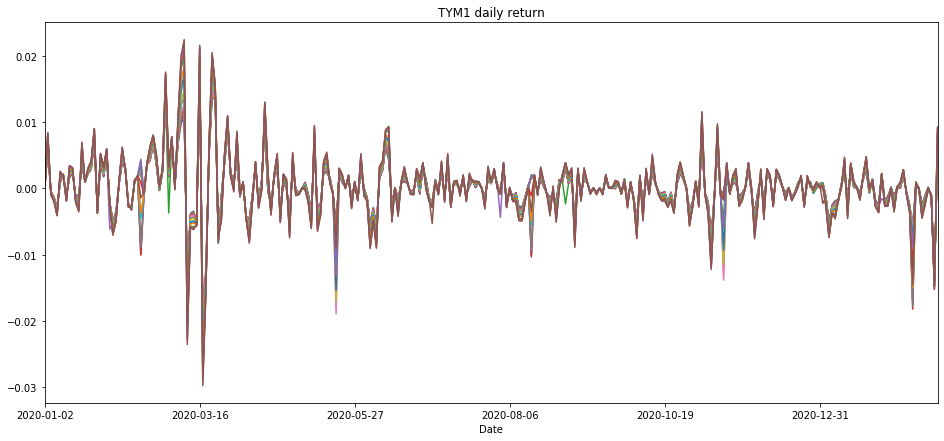

<Figure size 432x288 with 0 Axes>

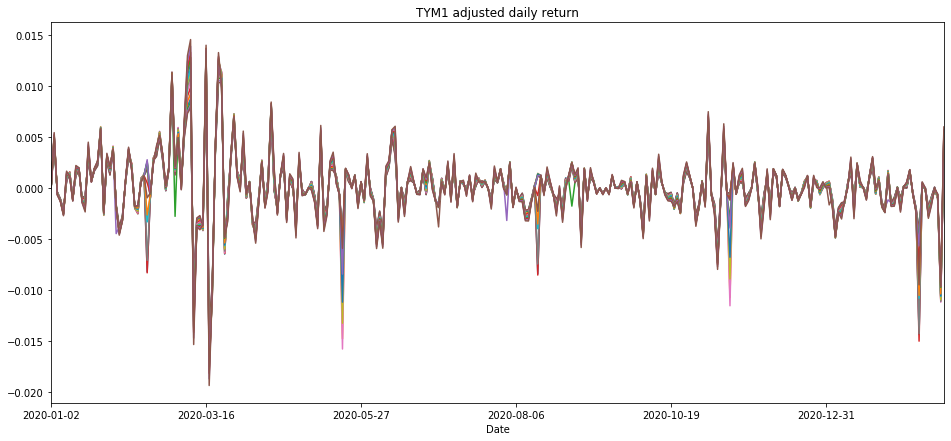

<Figure size 432x288 with 0 Axes>

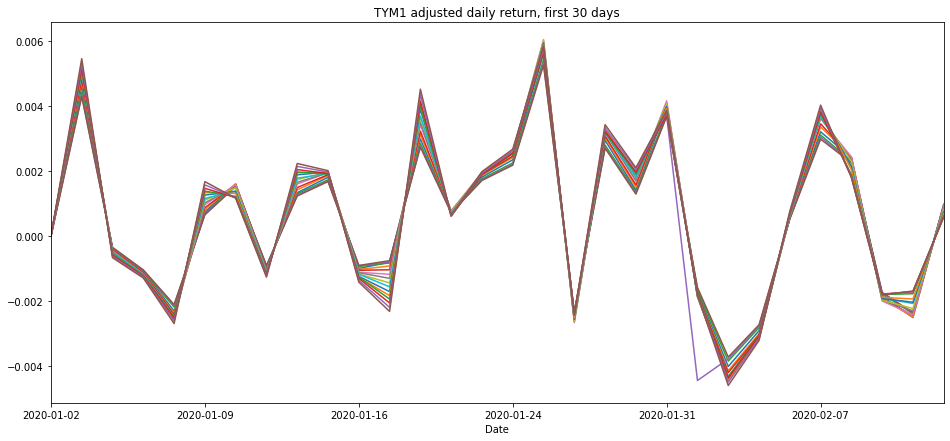

In [386]:
plt.figure()
TYM1_result['daily return'].plot(figsize=(16,7), legend=False)
plt.title('TYM1 daily return')

plt.figure()
TYM1_result['adjusted return'].plot(figsize=(16,7), legend=False)
plt.title('TYM1 adjusted daily return')


plt.figure()
TYM1_result['adjusted return'].head(30).plot(figsize=(16,7), legend=False)
plt.title('TYM1 adjusted daily return, first 30 days')

## Results for G_M1

In [387]:
for k, v in G_M1_result.items():
    print(k)
    display(v.head(10))

price


Bond,UKT 4 ¾ 12/07/30,UKT 4 ¼ 06/07/32,UKT 0 ⅜ 10/22/30,UKT 0 ¼ 07/31/31
Date,,,,
2020-01-02,128.786104,118.796807,84.593497,78.678614
2020-01-03,129.867673,120.383822,85.469420,79.771787
2020-01-06,129.771718,120.379921,85.404788,79.747356
2020-01-07,129.749355,120.299673,85.423537,79.755269
2020-01-08,129.610098,120.320287,85.302983,79.700836
2020-01-09,129.083993,119.870561,84.873826,79.305213
2020-01-10,129.630626,120.573577,85.304309,79.805111
2020-01-13,129.721895,120.731444,85.356978,79.882520
2020-01-14,130.414874,121.764782,85.907198,80.571641


YTM


Bond,UKT 4 ¾ 12/07/30,UKT 4 ¼ 06/07/32,UKT 0 ⅜ 10/22/30,UKT 0 ¼ 07/31/31
Date,,,,
2020-01-02,0.018637,0.025115,0.019830,0.023768
2020-01-03,0.017698,0.023779,0.018846,0.022548
2020-01-06,0.017798,0.023802,0.018933,0.022591
2020-01-07,0.017822,0.023876,0.018917,0.022588
2020-01-08,0.017949,0.023865,0.019058,0.022654
2020-01-09,0.018416,0.024251,0.019548,0.023102
2020-01-10,0.017943,0.023666,0.019066,0.022549
2020-01-13,0.017880,0.023553,0.019022,0.022479
2020-01-14,0.017282,0.022696,0.018408,0.021719


Duration


Bond,UKT 4 ¾ 12/07/30,UKT 4 ¼ 06/07/32,UKT 0 ⅜ 10/22/30,UKT 0 ¼ 07/31/31
Date,,,,
2020-01-02,8.927262,9.997840,10.511677,11.382433
2020-01-03,8.934319,10.014065,10.510575,11.381580
2020-01-06,8.925059,10.005521,10.502212,11.373294
2020-01-07,8.922059,10.001733,10.499498,11.370559
2020-01-08,8.917997,9.999146,10.496525,11.367717
2020-01-09,8.910396,9.990938,10.492970,11.364286
2020-01-10,8.912588,9.996494,10.491032,11.362400
2020-01-13,8.905027,9.989872,10.482886,11.354289
2020-01-14,8.908509,9.999218,10.481163,11.352713


Convexity


Bond,UKT 4 ¾ 12/07/30,UKT 4 ¼ 06/07/32,UKT 0 ⅜ 10/22/30,UKT 0 ¼ 07/31/31
Date,,,,
2020-01-02,97.346571,121.306275,120.296364,139.185687
2020-01-03,97.524800,121.708922,120.377524,139.318151
2020-01-06,97.348178,121.532331,120.187505,139.120241
2020-01-07,97.291371,121.450748,120.130640,139.057171
2020-01-08,97.209783,121.398248,120.051486,138.982956
2020-01-09,97.045814,121.209919,119.922684,138.847560
2020-01-10,97.110089,121.354294,119.932062,138.872708
2020-01-13,96.973480,121.224445,119.761145,138.693288
2020-01-14,97.067869,121.460829,119.789161,138.751226


adjusted price


Bond,UKT 4 ¾ 12/07/30,UKT 4 ¼ 06/07/32,UKT 0 ⅜ 10/22/30,UKT 0 ¼ 07/31/31
Date,,,,
2020-01-02,136.369828,121.422942,60.782390,54.231588
2020-01-03,137.515086,123.045039,61.411762,54.985089
2020-01-06,137.413482,123.041052,61.365321,54.968249
2020-01-07,137.389802,122.959030,61.378793,54.973704
2020-01-08,137.242344,122.980099,61.292173,54.936184
2020-01-09,136.685259,122.520432,60.983813,54.663489
2020-01-10,137.264081,123.238989,61.293125,55.008059
2020-01-13,137.360724,123.400345,61.330969,55.061415
2020-01-14,138.094511,124.456526,61.726314,55.536412


daily return


Bond,UKT 4 ¾ 12/07/30,UKT 4 ¼ 06/07/32,UKT 0 ⅜ 10/22/30,UKT 0 ¼ 07/31/31
Date,,,,
2020-01-02,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.008398,0.013359,0.010355,0.013894
2020-01-06,-0.000739,-0.000032,-0.000756,-0.000306
2020-01-07,-0.000172,-0.000667,0.000220,0.000099
2020-01-08,-0.001073,0.000171,-0.001411,-0.000683
2020-01-09,-0.004059,-0.003738,-0.005031,-0.004964
2020-01-10,0.004235,0.005865,0.005072,0.006303
2020-01-13,0.000704,0.001309,0.000617,0.000970
2020-01-14,0.005342,0.008559,0.006446,0.008627


adjusted return


Bond,UKT 4 ¾ 12/07/30,UKT 4 ¼ 06/07/32,UKT 0 ⅜ 10/22/30,UKT 0 ¼ 07/31/31
Date,,,,
2020-01-02,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.008893,0.013654,0.007440,0.009577
2020-01-06,-0.000782,-0.000033,-0.000543,-0.000211
2020-01-07,-0.000182,-0.000681,0.000158,0.000068
2020-01-08,-0.001136,0.000175,-0.001014,-0.000470
2020-01-09,-0.004298,-0.003820,-0.003615,-0.003421
2020-01-10,0.004484,0.005994,0.003644,0.004345
2020-01-13,0.000746,0.001338,0.000444,0.000669
2020-01-14,0.005657,0.008748,0.004632,0.005946


DCTD


Date
2020-01-02    UKT 0 ¼ 07/31/31
2020-01-03    UKT 0 ¼ 07/31/31
2020-01-06    UKT 0 ¼ 07/31/31
2020-01-07    UKT 0 ¼ 07/31/31
2020-01-08    UKT 0 ¼ 07/31/31
2020-01-09    UKT 0 ¼ 07/31/31
2020-01-10    UKT 0 ¼ 07/31/31
2020-01-13    UKT 0 ¼ 07/31/31
2020-01-14    UKT 0 ¼ 07/31/31
2020-01-15    UKT 0 ¼ 07/31/31
dtype: object

adjusted return for DCTD


2020-01-02    0.000000
2020-01-03    0.009577
2020-01-06   -0.000211
2020-01-07    0.000068
2020-01-08   -0.000470
2020-01-09   -0.003421
2020-01-10    0.004345
2020-01-13    0.000669
2020-01-14    0.005946
2020-01-15    0.005464
dtype: float64

test


Bond,UKT 4 ¾ 12/07/30,UKT 4 ¼ 06/07/32,UKT 0 ⅜ 10/22/30,UKT 0 ¼ 07/31/31
Date,,,,
2020-01-02,1.058886,1.022106,0.718523,0.68928
2020-01-03,1.058886,1.022106,0.718523,0.68928
2020-01-06,1.058886,1.022106,0.718523,0.68928
2020-01-07,1.058886,1.022106,0.718523,0.68928
2020-01-08,1.058886,1.022106,0.718523,0.68928
2020-01-09,1.058886,1.022106,0.718523,0.68928
2020-01-10,1.058886,1.022106,0.718523,0.68928
2020-01-13,1.058886,1.022106,0.718523,0.68928
2020-01-14,1.058886,1.022106,0.718523,0.68928


Text(0.5, 1.0, 'G_M1 adjusted daily return, first 30 days')

<Figure size 432x288 with 0 Axes>

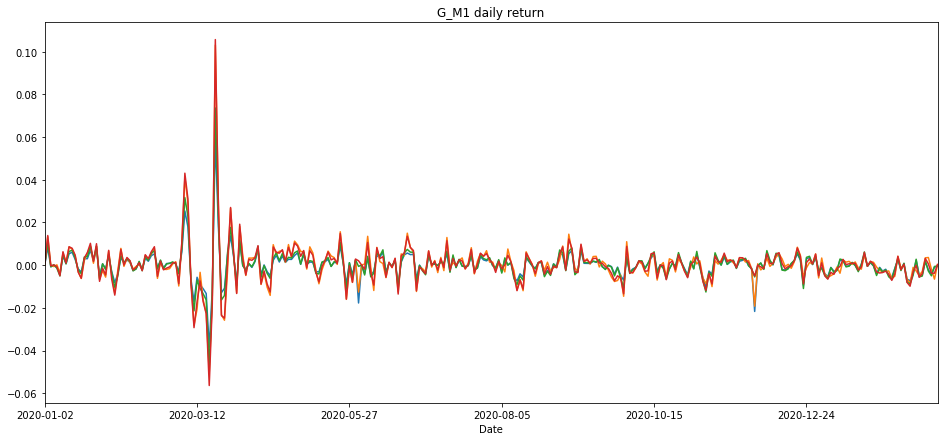

<Figure size 432x288 with 0 Axes>

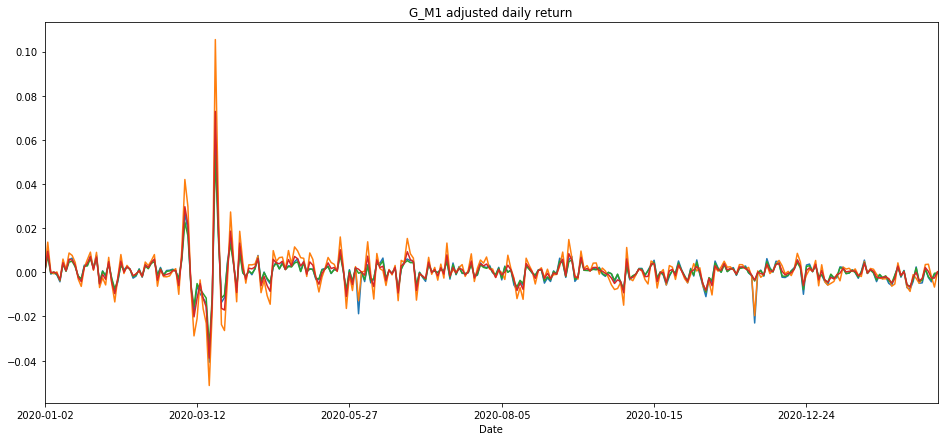

<Figure size 432x288 with 0 Axes>

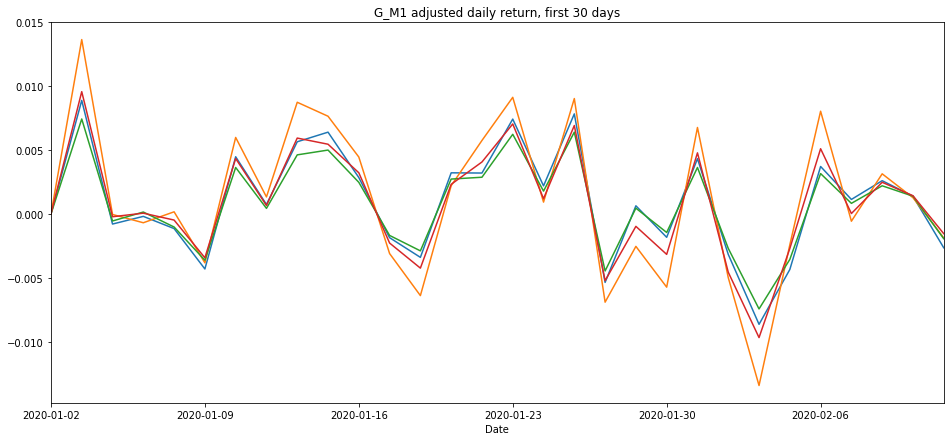

In [388]:
plt.figure()
G_M1_result['daily return'].plot(figsize=(16,7), legend=False)
plt.title('G_M1 daily return')

plt.figure()
G_M1_result['adjusted return'].plot(figsize=(16,7), legend=False)
plt.title('G_M1 adjusted daily return')


plt.figure()
G_M1_result['adjusted return'].head(30).plot(figsize=(16,7), legend=False)
plt.title('G_M1 adjusted daily return, first 30 days')

## For all three contracts, compare and comment on the daily rate of return in D and E

Text(0.5, 1.0, 'USM1')

<Figure size 432x288 with 0 Axes>

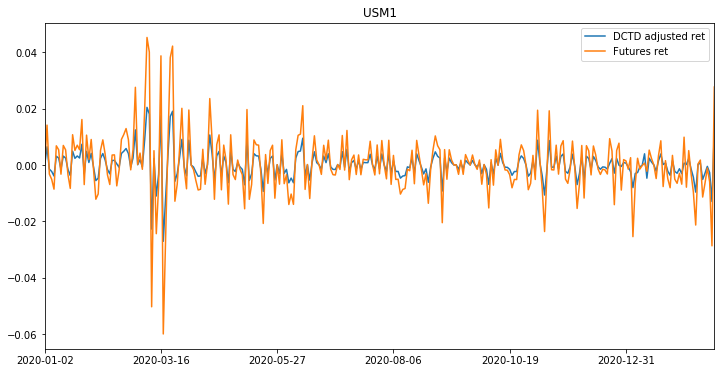

In [409]:
plt.figure()
USM1_rets.plot(figsize=(12, 6))
plt.title("USM1")

Text(0.5, 1.0, 'TYM1')

<Figure size 432x288 with 0 Axes>

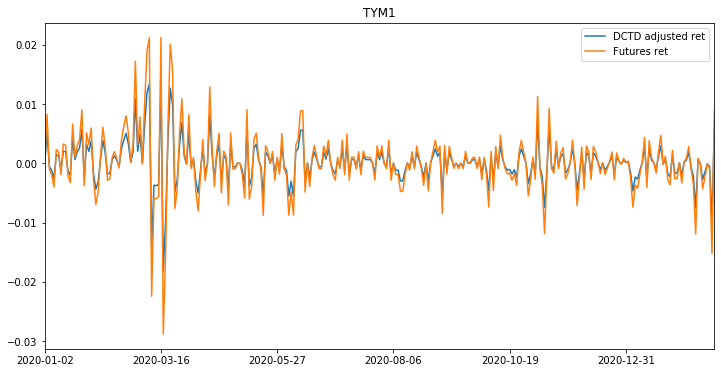

In [410]:
plt.figure()
TYM1_rets.plot(figsize=(12, 6))
plt.title("TYM1")


Text(0.5, 1.0, 'G_M1')

<Figure size 432x288 with 0 Axes>

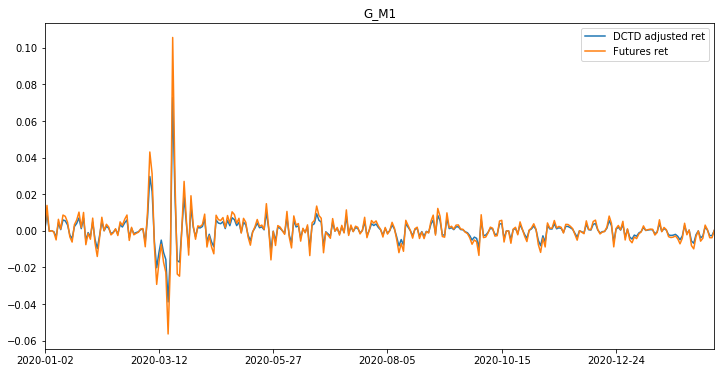

In [411]:
plt.figure()
G_M1_rets.plot(figsize=(12, 6))
plt.title("G_M1")


In [420]:
USM1_rets.cov()

,DCTD adjusted ret,Futures ret
DCTD adjusted ret,0.000025,0.000054
Futures ret,0.000054,0.000123


In [419]:
TYM1_rets.corr()

,DCTD adjusted ret,Futures ret
DCTD adjusted ret,1.0,1.0
Futures ret,1.0,1.0


In [415]:
G_M1_rets.corr()

,DCTD adjusted ret,Futures ret
DCTD adjusted ret,1.0,1.0
Futures ret,1.0,1.0
